<a href="https://colab.research.google.com/github/PlexusNetworkSystem/DeepLearning/blob/main/DNN/anamoly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
print("Running...")

Running...


In [ ]:


import os
import random
import numpy as np 
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, ImageDataGenerator

import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


In [ ]:
base_path = "/content/drive/MyDrive/Colab Notebooks/data_sets/"
SHAPE = (224,224,3)
batch_size = 256


In [ ]:
### PLOT IMAGES ###

def load_images_from_folder(folder):
    
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
        if len(images)>5:
            break
    
    plt.figure(figsize=(16,8))    
    for img,x in zip(images,range(1,7)):
        plt.subplot(2,3,x)
        plt.imshow(img)

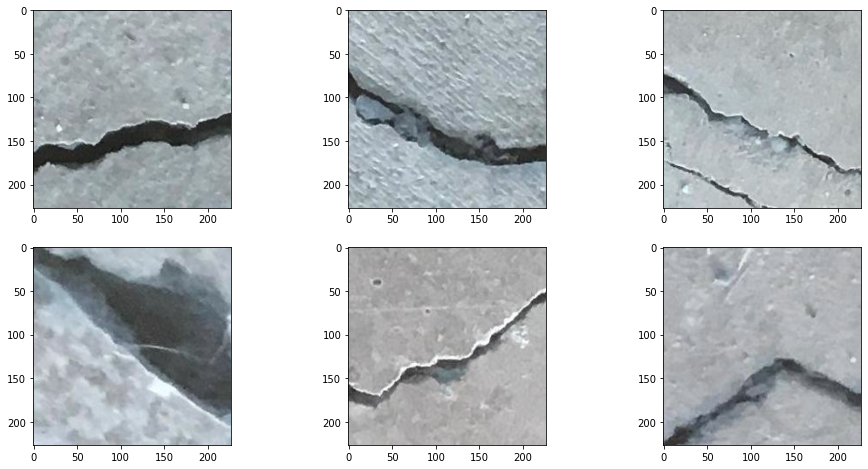

In [ ]:
### PLOT POSITIVE SAMPLES ###
load_images_from_folder(base_path + "Positive")
    


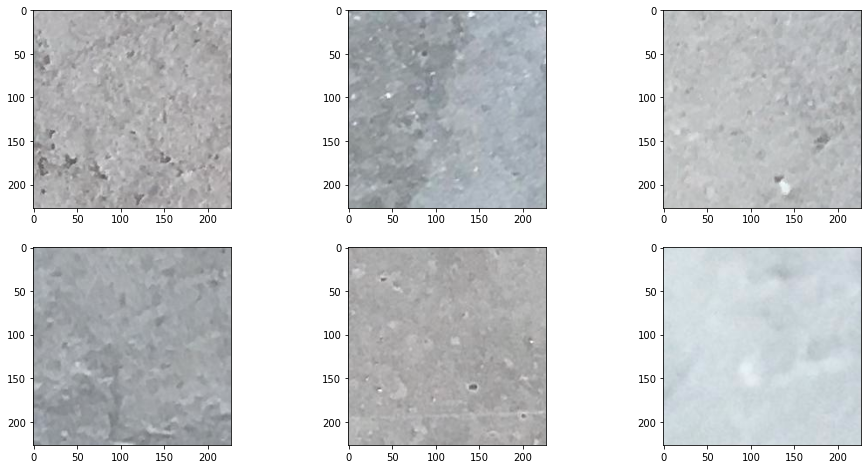

In [ ]:
### PLOT NEGATIVE SAMPLES ###
load_images_from_folder(base_path + "Negative")

In [ ]:


def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    
def get_model():
    
    set_seed(33)
    
    vgg = vgg16.VGG16(weights='imagenet', include_top=False, input_shape = SHAPE)

    for layer in vgg.layers[:-8]:
        layer.trainable = False

    x = vgg.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation="softmax")(x)

    model = Model(vgg.input, x)
    model.compile(loss = "categorical_crossentropy", 
                  optimizer = SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])
    
    return model



     


In [ ]:


### INITIALIZE GENERATORS ###

train_datagen = train_datagen = ImageDataGenerator(
        validation_split=0.3, rescale=1/255
)

test_datagen = ImageDataGenerator(
        validation_split=0.3, rescale=1/255
)



     


In [ ]:
### FLOW GENERATORS ###

train_generator = train_datagen.flow_from_directory(
            base_path,
            target_size = (SHAPE[0], SHAPE[1]),
            batch_size = batch_size,
            class_mode = 'categorical',
            shuffle = True,
            subset = 'training',
            seed = 33
)

test_generator = test_datagen.flow_from_directory(
            base_path,
            target_size = (SHAPE[0], SHAPE[1]),
            batch_size = batch_size,
            class_mode = 'categorical',
            shuffle = True,
            subset = 'validation',
            seed = 33
)

Found 1400 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [ ]:
### RETRIVE TEST LABEL FROM GENERATOR ###

test_num = test_generator.samples

label_test = []
for i in range((test_num // test_generator.batch_size)+1):
    X,y = test_generator.next()
    label_test.append(y)
        
label_test = np.argmax(np.vstack(label_test), axis=1)

label_test.shape



     


(600,)

In [ ]:

model = get_model()
model.fit(train_generator, steps_per_epoch=train_generator.samples/train_generator.batch_size, epochs=8)

     


58889256/58889256 [==============================] - 2s 0us/step


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/8
5/5 [==============================] - 250s 47s/step - loss: 0.8182 - accuracy: 0.5000
Epoch 2/8
5/5 [==============================] - 10s 2s/step - loss: 0.7265 - accuracy: 0.5000
Epoch 3/8
5/5 [==============================] - 10s 2s/step - loss: 0.6450 - accuracy: 0.7357
Epoch 4/8
5/5 [==============================] - 10s 2s/step - loss: 0.6122 - accuracy: 0.6379
Epoch 5/8
5/5 [==============================] - 10s 2s/step - loss: 0.5715 - accuracy: 0.7157
Epoch 6/8
5/5 [==============================] - 10s 2s/step - loss: 0.5294 - accuracy: 0.8564
Epoch 7/8
5/5 [==============================] - 11s 2s/step - loss: 0.4915 - accuracy: 0.8957
Epoch 8/8
5/5 [==============================] - 11s 2s/step - loss: 0.4525 - accuracy: 0.9014


In [ ]:


### PERFORMANCE ON TEST DATA ###

print(classification_report(label_test, np.argmax(model.predict(test_generator),axis=1)))



     


3/3 [==============================] - 10s 4s/step
              precision    recall  f1-score   support

           0       0.80      0.94      0.86       300
           1       0.92      0.77      0.84       300

    accuracy                           0.85       600
   macro avg       0.86      0.85      0.85       600
weighted avg       0.86      0.85      0.85       600



In [ ]:

def plot_activation(img):
  
    pred = model.predict(img[np.newaxis,:,:,:])
    pred_class = np.argmax(pred)

    weights = model.layers[-1].get_weights()[0]
    class_weights = weights[:, pred_class]

    intermediate = Model(model.input, model.get_layer("block5_conv3").output)
    conv_output = intermediate.predict(img[np.newaxis,:,:,:])
    conv_output = np.squeeze(conv_output)

    h = int(img.shape[0]/conv_output.shape[0])
    w = int(img.shape[1]/conv_output.shape[1])

    activation_maps = sp.ndimage.zoom(conv_output, (h, w, 1), order=1)
    out = np.dot(activation_maps.reshape((img.shape[0]*img.shape[1], 512)), class_weights).reshape(
        img.shape[0],img.shape[1])

    plt.imshow(img.astype('float32').reshape(img.shape[0],img.shape[1],3))
    plt.imshow(out, cmap='jet', alpha=0.35)
    plt.title('Crack' if pred_class == 1 else 'No Crack')


1/1 [==============================] - 0s 110ms/step


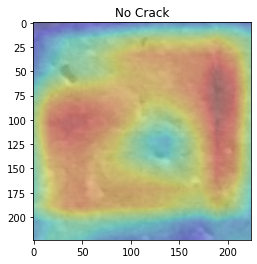

In [ ]:


### PLOT HEATMAPS ON TEST DATA ###

plot_activation(X[0])
     


1/1 [==============================] - 0s 104ms/step


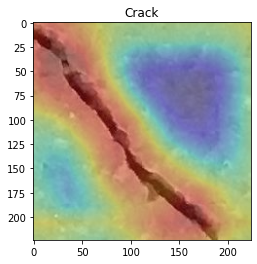

In [ ]:
plot_activation(X[1])


1/1 [==============================] - 0s 104ms/step


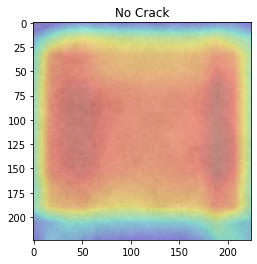

In [ ]:
plot_activation(X[2])


1/1 [==============================] - 0s 114ms/step


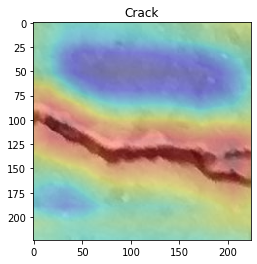

In [ ]:
plot_activation(X[3])